Importing

In [55]:
import torch
from torch.optim import Adamax
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from scipy import integrate # numerical integration tool for ode's

Physical System to Model: Spring, Mass, and Damper System

$ F(t) -c \frac{d\mathbf{x}}{d t}(t) - kx(t) = m\frac{d\mathbf{x^2}}{d t}(t)$

$\frac{d\mathbf{x^2}}{d t}(t) = ( F(t) -c \frac{d\mathbf{x}}{d t}(t) - kx(t) ) /m$

Text(0.5, 1.0, 'Numerical Solution to Spring, Mass, and Damper system')

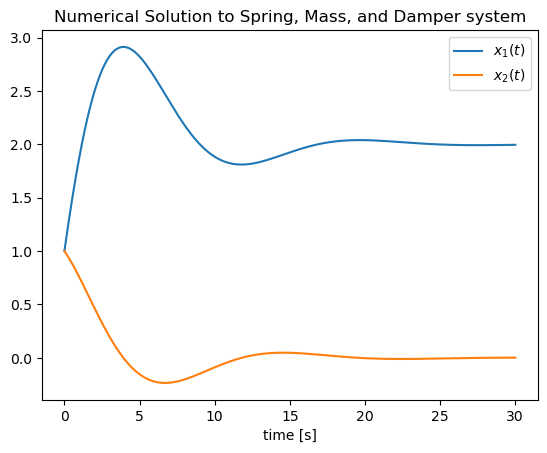

In [56]:
# Physical Parameters, c = damping constant, k =  stiffness of spring, m = mass.
p = dict(c=4, k=2, m=10, F=4)
#initial conditions
x0 = [1,1]
#plot to time T
T = 30

def f(x,t,p):
    x1, x2 = x[0], x[1]
    dx1 = x2
    dx2 = (p['F'] - p['c']*x2 - p['k']*x1) / p['m']
    return([dx1,dx2])

#Function to solve the physical system using numerical integration tool
def run_oscil(x0,T,p):
    t = np.linspace(0, T, 1000)
    dxdt = lambda x,t : f(x, t, p)
    x_t = integrate.odeint(dxdt, x0, t)
    return(t,x_t)

#Plotting neumerical solution
t_plot, x_plot = run_oscil(x0,T,p)
plt.plot(t_plot,x_plot)
plt.xlabel('time [s]')
#x_1 is position, x_2 is velocity
plt.legend(['$x_1(t)$','$x_2(t)$'])
plt.title("Numerical Solution to Spring, Mass, and Damper system")


The equation that models the Spring, Mass, and Damper System is the following:
$ F(t) = m\frac{d\mathbf{x^2}}{d t}(t) + c \frac{d\mathbf{x}}{d t}(t) + kx(t)$

The following parameters are needed to fully define the system:
1. Sum of Forces (F)
2. Mass (m)
3. Spring Constant (c)
4. Spring Stiffness (k)
5. Time (t)
6. Initial Conditions (x0)

These parameters can be used to determine the position (x) at current time (t).

Creating vectors for all parameters to be modelled

In [57]:
# number of vectors
#num = 1000

# Sampling x across t [0,30]
#t_train = torch.rand(num).view(-1,1)*30
#t_train = torch.linspace(0,30,1000).view(-1,1)
t_train,samples = run_oscil(x0,20,p)

t_train = torch.from_numpy(t_train).float().view(-1,1)
samples = samples[:,0]
samples = torch.from_numpy(samples).float().view(-1,1)

#setting other variables as constants
F_train = torch.ones_like(t_train)*p['F']
m_train = torch.ones_like(t_train)*p['m']
c_train = torch.ones_like(t_train)*p['c']
k_train = torch.ones_like(t_train)*p['k']
x0_1_train = torch.ones_like(t_train)*0
x0_2_train = torch.ones_like(t_train)*0

train = torch.cat((t_train, F_train, m_train, c_train, k_train, x0_1_train, x0_2_train),1)

Defining the Model, Loss and Optimizer

In [58]:
# len i/o nodes, i_len nodes per layer and ELU activation fn
i_len = 30

#params to take and approximate
params_in = 7
params_out = 1

model = nn.Sequential(
    nn.Linear(params_in, i_len),
    nn.ELU(),

    nn.Linear(i_len, i_len),
    nn.ELU(),
    nn.Linear(i_len, i_len),
    nn.ELU(),
    
    nn.Linear(i_len, params_out)
    )

# choose optimizer
optim = Adamax(model.parameters())

Creating a custom loss function using the following:

$ F(t) - m\frac{d\mathbf{x^2}}{d t}(t) - c \frac{d\mathbf{x}}{d t}(t) - kx(t)$ = 0


In [59]:
class CustomLoss(nn.Module):
    def __init__(self, weight=None, size_average=None, reduce=None, reduction='mean'):
        super(CustomLoss, self).__init__()
        # Define parameters you need for your loss function if needed.

    def forward(self, pred, inputs, sample):
        # pred: model's output
        # inputs: vector with cols 0:t, 1:F, 2:M, 3:c, 4:k, 5:x(0), 6:x'(0)

        # Obtaining parameters to compute loss.
        x = pred
        first_deriv = torch.autograd.grad(outputs=pred, inputs=inputs, grad_outputs=torch.ones_like(pred), create_graph=True, retain_graph=True, allow_unused=True)[0]
        second_deriv = torch.autograd.grad(outputs=first_deriv, inputs=inputs, grad_outputs=torch.ones_like(first_deriv), retain_graph=True)[0]

        x_1 = first_deriv[:, 0]
        x_2 = second_deriv[:, 0]
        F = inputs[:,1]
        m = inputs[:,2]
        c = inputs[:,3]
        k = inputs[:,4]

        # Calculate loss based on governing eqns
        phy = torch.square(F - m*x_2 - c*x_1 - k*x)
        phy = torch.sum(phy)

        # Calulate loss from sample
        SSE = torch.square(pred - sample)
        SSE = torch.sum(SSE)

        loss = SSE + phy  
        
        return loss

loss_fn = CustomLoss()

Train...

In [60]:
n_epochs = 1000
batch_size = 32

# Ensure requires_grad = true in input tensor.
train.requires_grad_(True)

for epoch in range(n_epochs):
    for b_num in range(0,len(train),batch_size):
        l = b_num
        u = l+batch_size
        batch = train[l:u,:]
        batch_samples = samples[l:u]
        
        pred = model(batch)
        loss = loss_fn(pred, batch, batch_samples)
        optim.zero_grad()
        loss.backward()
        optim.step()
    
    if not (epoch%100):
        print(f'Finished epoch {epoch}, latest loss {loss}')


Finished epoch 0, latest loss 0.03972110152244568
Finished epoch 100, latest loss 0.020292723551392555
Finished epoch 200, latest loss 0.012898179702460766
Finished epoch 300, latest loss 0.013406462967395782
Finished epoch 400, latest loss 0.013095262460410595
Finished epoch 500, latest loss 0.013774408958852291
Finished epoch 600, latest loss 0.013608312234282494
Finished epoch 700, latest loss 0.01270449161529541
Finished epoch 800, latest loss 0.03218178451061249
Finished epoch 900, latest loss 0.014683145098388195


Comparing plots of MLP approximation against numerical solution.

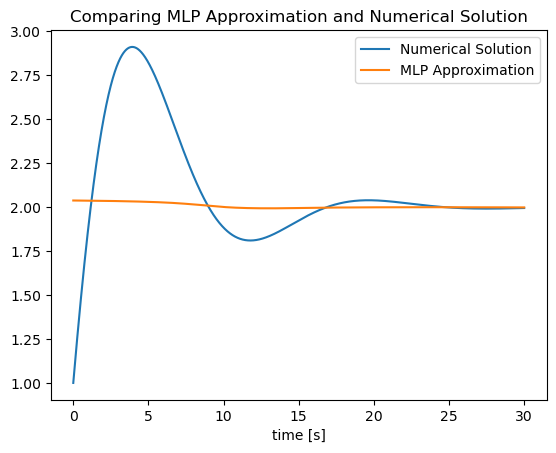

In [62]:
plt.plot(t_plot,x_plot[:,0],label='Numerical Solution')
plt.xlabel('time [s]')
plt.title("Comparing MLP Approximation and Numerical Solution")

# obtaining plotting information
# inputs: vector with cols 0:t, 1:F, 2:M, 3:c, 4:k, 5:x(0), 6:x'(0)

#creating tensors to be plotted
plot_t = torch.from_numpy(t_plot).float().view(-1,1)
plot_F = torch.ones_like(plot_t)*p['F']
plot_m = torch.ones_like(plot_t)*p['m']
plot_c = torch.ones_like(plot_t)*p['c']
plot_k = torch.ones_like(plot_t)*p['k']
plot_x0_1 = torch.ones_like(plot_t)*0
plot_x0_2 = torch.ones_like(plot_t)*0

plot_input = torch.cat((plot_t,plot_F,plot_m,plot_c,plot_k,plot_x0_1,plot_x0_2), 1)
pred = model(plot_input)
pred_plot = torch.reshape(pred, (-1,)).detach().numpy()

plt.plot(t_plot,pred_plot,label='MLP Approximation')
plt.legend()